# Employee Attrition Prediction

## Env setup

In [30]:

import sys, platform
import numpy as np, pandas as pd
import sklearn, xgboost, joblib


In [31]:
print("Python:", sys.version.splitlines()[0])
print("OS:", platform.platform())
print("numpy:", np.__version__, "pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__, "xgboost:", xgboost.__version__)


Python: 3.14.2 (tags/v3.14.2:df79316, Dec  5 2025, 17:18:21) [MSC v.1944 64 bit (AMD64)]
OS: Windows-11-10.0.22000-SP0
numpy: 2.3.5 pandas: 2.3.3
scikit-learn: 1.8.0 xgboost: 3.1.2


## load data

In [32]:

DATA_PATH = "../data/attrition.csv"  
df = pd.read_csv(DATA_PATH)
print("rows, cols:", df.shape)
display(df.head(5))
display(df.info())
display(df.isna().sum().sort_values(ascending=False).head(20))
print("Target distribution:\n", df['attrition'].value_counts(dropna=False))
print("Duplicated rows:", df.duplicated().sum())


rows, cols: (300, 11)


,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1,0
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2,0
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1,0
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4,0
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 300 non-null    int64 
 1   gender              300 non-null    object
 2   education           300 non-null    object
 3   department          300 non-null    object
 4   job_role            300 non-null    object
 5   monthly_income      300 non-null    int64 
 6   years_at_company    300 non-null    int64 
 7   promotions          300 non-null    int64 
 8   overtime            300 non-null    object
 9   performance_rating  300 non-null    int64 
 10  attrition           300 non-null    int64 
dtypes: int64(6), object(5)
memory usage: 25.9+ KB


None

age                   0
gender                0
education             0
department            0
job_role              0
monthly_income        0
years_at_company      0
promotions            0
overtime              0
performance_rating    0
attrition             0
dtype: int64

Target distribution:
 attrition
0    231
1     69
Name: count, dtype: int64
Duplicated rows: 0


## data quality assertions

In [33]:

# 1) Ensure target is 0/1 numeric
if df['attrition'].dtype == 'O':
    df['attrition'] = df['attrition'].map({'Yes':1,'No':0}).astype(int)

# 2) Drop exact duplicate rows 
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates, new shape:", df.shape)

# 3) Basic value sanity checks 
assert df['age'].min() >= 16, "Found age < 16, inspect data"
assert set(df['attrition'].unique()) <= {0,1}, "Target not binary"

# 4) Print class balance percent
print("Attrition rate: {:.2f}%".format(df['attrition'].mean()*100))


Attrition rate: 23.00%


## split feature groups programmatically

In [34]:
target_col = 'attrition'
all_cols = df.columns.tolist()
feature_cols = [c for c in all_cols if c != target_col]

numeric_candidates = ['age','years_at_company','monthly_income','promotions','performance_rating']
numeric_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in feature_cols if c not in numeric_cols]



In [35]:

print("Numeric cols detected:", numeric_cols)
print("Categorical cols detected:", cat_cols)

Numeric cols detected: ['age', 'monthly_income', 'years_at_company', 'promotions', 'performance_rating']
Categorical cols detected: ['gender', 'education', 'department', 'job_role', 'overtime']


## EDA

In [36]:

display(df[numeric_cols].describe().T)

for c in cat_cols:
    top = df.groupby(c)[target_col].mean().sort_values(ascending=False).head(5)
    print(f"\nTop attrition groups for {c}:")
    display(top)


,count,mean,std,min,25%,50%,75%,max
age,300.0,41.186667,11.275739,22.0,30.00,43.0,51.0,59.0
monthly_income,300.0,69834.483333,28201.559946,20060.0,46111.75,69012.0,94733.0,119804.0
years_at_company,300.0,7.243333,4.454616,0.0,3.00,8.0,11.0,14.0
promotions,300.0,2.073333,1.421745,0.0,1.00,2.0,3.0,4.0
performance_rating,300.0,2.500000,1.172426,1.0,1.00,2.5,4.0,4.0



Top attrition groups for gender:


gender
Male      0.243056
Female    0.217949
Name: attrition, dtype: float64


Top attrition groups for education:


education
Graduate         0.245614
PhD              0.241758
Post-Graduate    0.200000
Name: attrition, dtype: float64


Top attrition groups for department:


department
HR         0.265060
Finance    0.253165
IT         0.222222
Sales      0.166667
Name: attrition, dtype: float64


Top attrition groups for job_role:


job_role
Manager      0.272727
Executive    0.230000
Lead         0.188119
Name: attrition, dtype: float64


Top attrition groups for overtime:


overtime
Yes    0.240876
No     0.220859
Name: attrition, dtype: float64

## ---- preprocessing pipeline

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder



In [38]:
# Decide which categorical are ordinal 
ordinal_mappings = {
}
ord_cols = [c for c in cat_cols if c in ordinal_mappings]
nominal_cols = [c for c in cat_cols if c not in ord_cols]

# Numeric transformer
num_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])



In [39]:
# Ordinal transformer
ord_transformers = []
if ord_cols:
    ord_transformer = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[ordinal_mappings[c] for c in ord_cols]))
    ])

# Nominal transformer 
cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [40]:
# Combine
transformers = []
transformers.append(('num', num_transformer, numeric_cols))
if ord_cols:
    transformers.append(('ord', ord_transformer, ord_cols))
transformers.append(('cat', cat_transformer, nominal_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

## data split


In [41]:

from sklearn.model_selection import train_test_split
X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train class balance:", y_train.value_counts(normalize=True).to_dict())
print("Test class balance:", y_test.value_counts(normalize=True).to_dict())


Train: (240, 10) Test: (60, 10)
Train class balance: {0: 0.7708333333333334, 1: 0.22916666666666666}
Test class balance: {0: 0.7666666666666667, 1: 0.23333333333333334}


## Logistic Regression pipeline

In [42]:
# Cell: Logistic Regression baseline with cross-validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
scoring = ['accuracy','precision','recall','f1','roc_auc']

lr_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results_lr = cross_validate(lr_pipeline, X_train, y_train, cv=cv,
                               scoring=scoring, return_train_score=False)



## cv

In [43]:
import numpy as np
def summarize_cv(results):
    summary = {k: (np.mean(v), np.std(v)) for k,v in results.items() if k.startswith('test_')}
    return summary

lr_summary = summarize_cv(cv_results_lr)
print("Logistic Regression CV summary:")
for k,(m,s) in lr_summary.items():
    print(f"{k}: {m:.4f} ± {s:.4f}")

Logistic Regression CV summary:
test_accuracy: 0.4875 ± 0.0568
test_precision: 0.1883 ± 0.0631
test_recall: 0.3818 ± 0.1455
test_f1: 0.2512 ± 0.0863
test_roc_auc: 0.4226 ± 0.0600


## XGBoost pipeline

In [44]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs= -1, random_state=42))
])

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 5, 7, 9],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    # scale_pos_weight helps if positive class is rare
    'clf__scale_pos_weight': [max(1, int((y_train==0).sum()/(y_train==1).sum())), 1, 5, 10]
}


## RandomizedSearchCV

In [45]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(xgb_pipeline, param_distributions=param_dist,
                        n_iter=30, cv=cv, scoring='roc_auc', verbose=2, n_jobs=4, random_state=42)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV ROC-AUC:", rs.best_score_)
best_xgb = rs.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


e:\project\2025\Assignment\Massai\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:24:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'clf__subsample': 1.0, 'clf__scale_pos_weight': 5, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.2, 'clf__colsample_bytree': 0.8}
Best CV ROC-AUC: 0.5061425061425061


## evaluate models on holdout test set & comparison table

In [46]:
# Cell: Final evaluation on holdout test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
models = {
    'LogisticRegression': lr_pipeline.fit(X_train, y_train),
    'XGBoost_tuned': best_xgb
}

def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    print(f"\n{name} classification report:\n", classification_report(y_test, y_pred, zero_division=0))
    print(f"{name} Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    return metrics

results = {}
for name,model in models.items():
    results[name] = evaluate_model(name, model)

# Comparison table
results_df = pd.DataFrame(results).T
display(results_df)



LogisticRegression classification report:
               precision    recall  f1-score   support

           0       0.82      0.50      0.62        46
           1       0.28      0.64      0.39        14

    accuracy                           0.53        60
   macro avg       0.55      0.57      0.51        60
weighted avg       0.70      0.53      0.57        60

LogisticRegression Confusion matrix:
 [[23 23]
 [ 5  9]]

XGBoost_tuned classification report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.76        46
           1       0.09      0.07      0.08        14

    accuracy                           0.62        60
   macro avg       0.41      0.43      0.42        60
weighted avg       0.58      0.62      0.60        60

XGBoost_tuned Confusion matrix:
 [[36 10]
 [13  1]]


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.533333,0.281250,0.642857,0.391304,0.527950
XGBoost_tuned,0.616667,0.090909,0.071429,0.080000,0.431677


## Calibration check & optional calibration


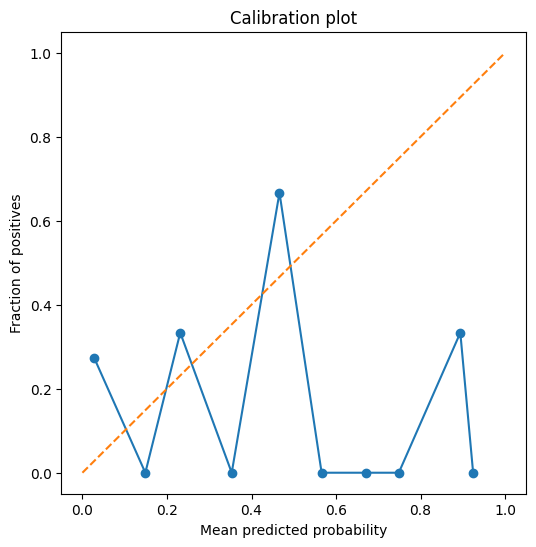

In [47]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

final_model = best_xgb  # choose model you prefer

y_proba = final_model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot")
plt.show()



## feature importance: permutation + SHAP

permutation importance validates SHAP and reduces false positives from correlated features.

In [48]:
from sklearn.inspection import permutation_importance
import numpy as np


raw_feature_names = X_test.columns

perm = permutation_importance(best_xgb, X_test, y_test, scoring='roc_auc', n_repeats=20, random_state=42, n_jobs=4)
perm_imp = pd.Series(perm.importances_mean, index=raw_feature_names)
perm_imp = perm_imp.sort_values(ascending=False).head(20)
display(perm_imp)



education             0.038509
job_role              0.009705
age                   0.005357
performance_rating    0.002562
overtime              0.002329
gender               -0.001863
years_at_company     -0.004193
department           -0.027096
monthly_income       -0.059705
promotions           -0.079193
dtype: float64

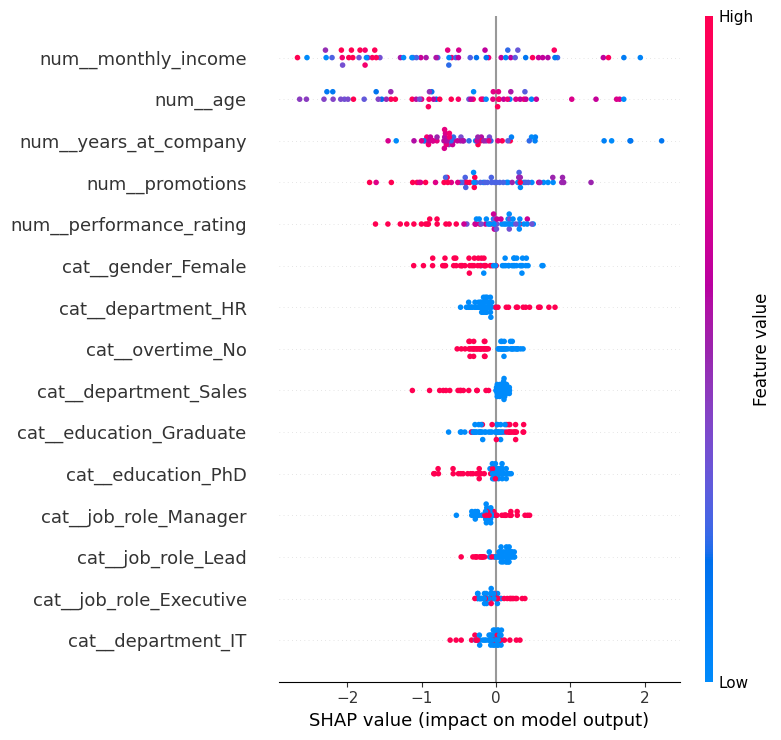

In [53]:
# SHAP (TreeExplainer)
import shap
# If X is transformed by preprocessor, we should get the feature names:
feature_names = preprocessor.get_feature_names_out()
X_test_trans_df = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names)
explainer = shap.TreeExplainer(best_xgb.named_steps['clf'])
shap_values = explainer.shap_values(X_test_trans_df)  # shape: (n_rows, n_features)
# SHAP summary plot (global)
shap.summary_plot(shap_values, X_test_trans_df, max_display=15)


## produce ranked list of top drivers


In [54]:

shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'feature': X_test_trans_df.columns, 'mean_abs_shap': shap_abs_mean})
shap_df = shap_df.sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)
display(shap_df.head(15))

from scipy.stats import spearmanr
directions = []
for col in X_test_trans_df.columns:
    corr, _ = spearmanr(X_test_trans_df[col], shap_values[:, X_test_trans_df.columns.get_loc(col)])
    directions.append(corr)
shap_df['spearman_corr_with_shap'] = directions
shap_df['direction'] = shap_df['spearman_corr_with_shap'].apply(lambda x: 'increases_attrition' if x>0 else 'decreases_attrition')
display(shap_df.head(10))


,feature,mean_abs_shap
0,num__monthly_income,1.143674
1,num__age,0.976023
2,num__years_at_company,0.660795
3,num__promotions,0.532611
4,num__performance_rating,0.389943
5,cat__gender_Female,0.356318
6,cat__department_HR,0.229025
7,cat__overtime_No,0.211712
8,cat__department_Sales,0.198457
9,cat__education_Graduate,0.193642


,feature,mean_abs_shap,spearman_corr_with_shap,direction
0,num__monthly_income,1.143674,0.180807,increases_attrition
1,num__age,0.976023,-0.209114,decreases_attrition
2,num__years_at_company,0.660795,-0.407353,decreases_attrition
3,num__promotions,0.532611,-0.477423,decreases_attrition
4,num__performance_rating,0.389943,-0.671721,decreases_attrition
5,cat__gender_Female,0.356318,-0.828918,decreases_attrition
6,cat__department_HR,0.229025,0.840525,increases_attrition
7,cat__overtime_No,0.211712,0.673018,increases_attrition
8,cat__department_Sales,0.198457,-0.789712,decreases_attrition
9,cat__education_Graduate,0.193642,-0.182032,decreases_attrition


## save artifacts (preprocessor + model)


In [56]:
# Save preprocessing and model artifacts
import joblib
joblib.dump(preprocessor, "models/preprocessor.joblib")
joblib.dump(best_xgb, "models/xgb_best.joblib")
print("Saved preprocessor and model to models/")


Saved preprocessor and model to models/


## ----------------------------------------

## Test

In [57]:


def predict_attrition_proba(row_dict):
    """
    row_dict: dict of feature_name -> value (single employee)
    returns: probability of attrition (float)
    """
    row_df = pd.DataFrame([row_dict])
    proba = best_xgb.predict_proba(row_df)[:,1][0]
    return float(proba)

# Example: adapt this with a real row
sample = X_test.iloc[0].to_dict()
print("Sample probability:", predict_attrition_proba(sample))


Sample probability: 0.0021428067702800035
